In [1]:
import numpy as np
import pandas as pd

# Config

In [ ]:
HYPER_OPT = True 
HYPER_OPT_TIME = 3600*5
USE_ORIGINAL_DATA = False 

In [3]:
import shutil
import os
from pathlib import Path

# Define input and output directories
input_dir = Path("/kaggle/input")
output_dir = Path("/kaggle/working")

# Find and copy all .db files
for db_file in input_dir.rglob("*.db"):
    shutil.copy(db_file, output_dir / db_file.name)

print("All .db files have been copied to the output directory.")

All .db files have been copied to the output directory.


# Data Extraction

In [ ]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv", index_col='id')

test_df = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv", index_col='id')

original_df = pd.read_csv("/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv")

test_var = 0

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s4e12/train.csv'

# Data Cleaning

In [5]:
original_df = original_df.dropna(subset=["Premium Amount"])

In [6]:
def preprocess(df_in):
    df = df_in.copy()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    
    df[categorical_features] = df[categorical_features].fillna("Unknown")

    for col in categorical_features:
        df[col] = df[col].astype('category')
    
    df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])
    df["Month"]       = df["Policy Start Date"].dt.month
    df["Day"]         = df["Policy Start Date"].dt.day
    df["Week"]        = df["Policy Start Date"].dt.isocalendar().week
    df["Weekday"]     = df["Policy Start Date"].dt.weekday
    df['DaySin']      = np.sin(2 * np.pi * df['Day'] / 30)  
    df['DayCos']      = np.cos(2 * np.pi * df['Day'] / 30)
    df['WeekdaySin']  = np.sin(2 * np.pi * df['Weekday'] / 7)
    df['WeekdayCos']  = np.cos(2 * np.pi * df['Weekday'] / 7)
    
    df['DaysSinceStart']  = \
    np.ceil(
        (pd.to_datetime("12-31-2024") - df["Policy Start Date"])/ pd.Timedelta(1, "d")
    )

    df = df.drop("Policy Start Date", axis=1, errors = "ignore")

    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)
original_df = preprocess(original_df)

# Data Splitting

In [7]:
X_train = train_df.drop('Premium Amount', axis=1)
#X_train["Premium Amount"] = np.log1p(X_train['Premium Amount'].values)
y_train = pd.DataFrame(np.log1p(train_df['Premium Amount'].values))

X_test = test_df

if USE_ORIGINAL_DATA:
    X_train["Synthetic"] = 1
    X_test["Synthetic"] = 1
    X_orig["Synthetic"] = 0
    X_orig = original_df.drop('Premium Amount', axis=1)
    y_orig = pd.DataFrame(np.log1p(original_df['Premium Amount'].values))
    
else:
    X_orig = None

# Training Function

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def train_model_cv(model, X_train, y_train, X_test, X_orig, cv_splits=7, early_stopping_rounds=None):
    # Initialize the K-Fold for CV
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=84)
    
    # Initialize placeholders for results
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    cv_scores = np.zeros(cv_splits)
    best_iterations = np.zeros(cv_splits)
    models = []
    
    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Training fold {fold + 1}...")
        
        # Split data
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        if X_orig is not None:
            # Append rows
            X_train_fold = pd.concat([X_train_fold, X_orig], ignore_index=True)
            y_train_fold = pd.concat([y_train_fold, y_orig], ignore_index=True)
        
        # Fit the model on training data
        if early_stopping_rounds:
            model.fit(
                X_train_fold, y_train_fold, 
                eval_set=(X_val_fold, y_val_fold),
                early_stopping_rounds=early_stopping_rounds,
                verbose=False
            )
            best_iterations[fold]=model.get_best_iteration()
        else:
            model.fit(X_train_fold, y_train_fold)
        
        # Predict on validation and test data
        oof_preds[val_idx] = model.predict(X_val_fold)
        test_preds += model.predict(X_test)
        
        # Calculate score for this fold
        fold_score = mean_squared_error(y_val_fold, oof_preds[val_idx], squared=False)
        cv_scores[fold] = fold_score
        models.append(model)
        
        print(f"Fold {fold + 1} RMSE: {fold_score:.4f}")
    
    # Summary statistics
    test_preds /= cv_splits
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    best_iteration = best_iterations.mean()
    print(f"Mean CV RMSE: {mean_score:.4f} ± {std_score:.4f}")

    return {\
        "oof_preds": oof_preds,
        "test_preds": test_preds,
        "cv_scores": cv_scores,
        "models": models,
        "best_iteration": int(best_iterations.mean())
    }


# LGBM Wrapper

In [9]:
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import pandas as pd

class XGBRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.params = kwargs

    def fit(self, X, y, eval_set=None, early_stopping_rounds=None, verbose=False):
        """
        Train the XGBRegressor model.

        Parameters:
        - X: pd.DataFrame or array-like
          Training features.
        - y: array-like
          Training labels.
        - eval_set: tuple or None
          Optional validation set for early stopping, in the form [(X_val, y_val)].
        - early_stopping_rounds: int or None
          Number of rounds for early stopping. Set to None to disable.
        - verbose: bool
          Whether to print training progress.
        """
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Initialize and train the XGB Regressor
        self.xgb_model_ = XGBRegressor(**self.params)

        # Train the model with early stopping if validation set is provided
        self.xgb_model_.fit(
            X,
            y,
            eval_set=[eval_set],
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose
        )
        
        return self

    def predict(self, X):
        return self.xgb_model_.predict(X)

    def get_best_iteration(self):
        """
        Get the best iteration for early stopping.
        """
        return self.xgb_model_.best_iteration if hasattr(self.xgb_model_, "best_iteration") else None

    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **parameters):
        self.params.update(parameters)
        return self


# HyperOpt

[I 2024-12-09 13:12:57,209] Using an existing study with name 'XGB_v1' instead of creating a new one.


Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0511
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0501
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0484
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0509
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 13:15:07,678] Trial 2 finished with value: 1.050071470999665 and parameters: {'learning_rate': 0.05433350003437882, 'max_depth': 14, 'min_child_weight': 1.509804001525835, 'subsample': 0.8367148343488449, 'colsample_bytree': 0.9708747744678036, 'gamma': 0.06351598517383816, 'lambda': 0.04511809923805299, 'alpha': 0.0015676574662308934}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0499
Mean CV RMSE: 1.0501 ± 0.0010
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0482
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0471
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0458
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0483
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 13:40:51,218] Trial 3 finished with value: 1.0472749183269143 and parameters: {'learning_rate': 0.001768215377734423, 'max_depth': 12, 'min_child_weight': 0.008728853020978604, 'subsample': 0.8464925012884582, 'colsample_bytree': 0.5157352018243503, 'gamma': 3.5042237608299063, 'lambda': 0.014890607747597583, 'alpha': 1.2529040614881077}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0469
Mean CV RMSE: 1.0473 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0512
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0500
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0486
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0516
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 13:58:20,376] Trial 4 finished with value: 1.0503112392767011 and parameters: {'learning_rate': 0.0010295684202914674, 'max_depth': 8, 'min_child_weight': 0.003321757899981517, 'subsample': 0.5486009372170182, 'colsample_bytree': 0.4139417795433424, 'gamma': 3.6366057711758453, 'lambda': 0.02291605035157054, 'alpha': 0.006166129274351907}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0501
Mean CV RMSE: 1.0503 ± 0.0010
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0593
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0591
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0571
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0601
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 13:59:44,354] Trial 5 finished with value: 1.0587660896346929 and parameters: {'learning_rate': 0.17870968683687566, 'max_depth': 15, 'min_child_weight': 0.318876983451918, 'subsample': 0.5554791096213735, 'colsample_bytree': 0.7502875712951831, 'gamma': 1.6284532646680434, 'lambda': 3.594158746720598, 'alpha': 0.3203451159453505}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0583
Mean CV RMSE: 1.0588 ± 0.0010
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0528
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0513
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0503
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0525
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:00:46,304] Trial 6 finished with value: 1.0516196652326548 and parameters: {'learning_rate': 0.10677004453213144, 'max_depth': 12, 'min_child_weight': 0.09080655845269026, 'subsample': 0.8458283150473813, 'colsample_bytree': 0.6217578285385542, 'gamma': 0.375832719735959, 'lambda': 1.261165012072524, 'alpha': 0.007544613176679852}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0513
Mean CV RMSE: 1.0516 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0484
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0473
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0459
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0482
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:41:48,037] Trial 7 finished with value: 1.0473584085556067 and parameters: {'learning_rate': 0.001572316850677651, 'max_depth': 11, 'min_child_weight': 0.005273622710529421, 'subsample': 0.8970790799514776, 'colsample_bytree': 0.5148211407627984, 'gamma': 1.352044768751754, 'lambda': 0.17544366233758285, 'alpha': 4.069317345142579}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0469
Mean CV RMSE: 1.0474 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0532
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0522
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0501
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0535
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:42:27,160] Trial 8 finished with value: 1.052169929166623 and parameters: {'learning_rate': 0.1288199143020136, 'max_depth': 11, 'min_child_weight': 0.0706208895177166, 'subsample': 0.40973230799046567, 'colsample_bytree': 0.5795280231067159, 'gamma': 1.7688910936390445, 'lambda': 3.749822076655429, 'alpha': 1.394910288740228}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0519
Mean CV RMSE: 1.0522 ± 0.0012
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0502
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0491
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0476
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0499
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:43:09,868] Trial 9 finished with value: 1.0491461304418783 and parameters: {'learning_rate': 0.08143647168295229, 'max_depth': 11, 'min_child_weight': 4.431174429966464, 'subsample': 0.6785848861398642, 'colsample_bytree': 0.5090620994307342, 'gamma': 4.420128023795511, 'lambda': 0.7501862009222005, 'alpha': 0.48699578287890244}. Best is trial 1 with value: 1.0472523316254132.


Fold 5 RMSE: 1.0488
Mean CV RMSE: 1.0491 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0466
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0455
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0443
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0467
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:45:22,037] Trial 10 finished with value: 1.045701269712271 and parameters: {'learning_rate': 0.007176952704950727, 'max_depth': 9, 'min_child_weight': 0.0010132765301790316, 'subsample': 0.9718735612649867, 'colsample_bytree': 0.7649532045970595, 'gamma': 4.866253783371921, 'lambda': 0.0015209560794537172, 'alpha': 0.06113886951712445}. Best is trial 10 with value: 1.045701269712271.


Fold 5 RMSE: 1.0455
Mean CV RMSE: 1.0457 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0466
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0454
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0441
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0466
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:47:13,752] Trial 11 finished with value: 1.0456153332586045 and parameters: {'learning_rate': 0.006774194265739484, 'max_depth': 8, 'min_child_weight': 0.0013161923749060963, 'subsample': 0.9849761384625391, 'colsample_bytree': 0.7789615289131929, 'gamma': 4.637796452393854, 'lambda': 0.001497883860117175, 'alpha': 0.06158341058835293}. Best is trial 11 with value: 1.0456153332586045.


Fold 5 RMSE: 1.0454
Mean CV RMSE: 1.0456 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0454
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0441
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0466
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:48:53,212] Trial 12 finished with value: 1.0455847705250467 and parameters: {'learning_rate': 0.007816847668538279, 'max_depth': 8, 'min_child_weight': 0.0011802817505815284, 'subsample': 0.9809979114803905, 'colsample_bytree': 0.794044017662857, 'gamma': 4.974574933858394, 'lambda': 0.001027665566481728, 'alpha': 0.05014306198455059}. Best is trial 12 with value: 1.0455847705250467.


Fold 5 RMSE: 1.0454
Mean CV RMSE: 1.0456 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0440
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:50:20,053] Trial 13 finished with value: 1.0455543154276583 and parameters: {'learning_rate': 0.009318872690387052, 'max_depth': 8, 'min_child_weight': 0.0011667367933387276, 'subsample': 0.9812591057223314, 'colsample_bytree': 0.8462925039691034, 'gamma': 4.228426383107207, 'lambda': 0.0014881972229552906, 'alpha': 0.04777591717974788}. Best is trial 13 with value: 1.0455543154276583.


Fold 5 RMSE: 1.0454
Mean CV RMSE: 1.0456 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0454
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0441
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:51:21,956] Trial 14 finished with value: 1.0455607841138828 and parameters: {'learning_rate': 0.018312467402894314, 'max_depth': 9, 'min_child_weight': 25.859462104280446, 'subsample': 0.752674072806934, 'colsample_bytree': 0.8709125088927163, 'gamma': 4.0361732411909115, 'lambda': 0.0044758005939563045, 'alpha': 0.022786636733193116}. Best is trial 13 with value: 1.0455543154276583.


Fold 5 RMSE: 1.0453
Mean CV RMSE: 1.0456 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0454
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0440
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:52:23,692] Trial 15 finished with value: 1.0455858252761816 and parameters: {'learning_rate': 0.01936005592202294, 'max_depth': 9, 'min_child_weight': 24.585085121483036, 'subsample': 0.7228690046220589, 'colsample_bytree': 0.8752576393926808, 'gamma': 2.65814125520743, 'lambda': 0.005507251338225904, 'alpha': 0.013703941038110706}. Best is trial 13 with value: 1.0455543154276583.


Fold 5 RMSE: 1.0454
Mean CV RMSE: 1.0456 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0466
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0457
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0443
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0468
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:53:28,837] Trial 16 finished with value: 1.0457906171513214 and parameters: {'learning_rate': 0.020928966500164837, 'max_depth': 10, 'min_child_weight': 15.595398108034052, 'subsample': 0.6915577879551703, 'colsample_bytree': 0.8795240117527781, 'gamma': 3.9964929101349957, 'lambda': 0.0042732593896629215, 'alpha': 0.019796824737171727}. Best is trial 13 with value: 1.0455543154276583.


Fold 5 RMSE: 1.0455
Mean CV RMSE: 1.0458 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0464
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0440
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 14:57:54,195] Trial 17 finished with value: 1.04549099981163 and parameters: {'learning_rate': 0.0034010483287483318, 'max_depth': 9, 'min_child_weight': 0.03431196729446624, 'subsample': 0.7504427941400956, 'colsample_bytree': 0.8685927278377555, 'gamma': 2.8572184865327923, 'lambda': 0.006271748575588627, 'alpha': 0.26010716264185463}. Best is trial 17 with value: 1.04549099981163.


Fold 5 RMSE: 1.0453
Mean CV RMSE: 1.0455 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0471
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0460
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0447
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0471
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:05:45,492] Trial 18 finished with value: 1.046164349336941 and parameters: {'learning_rate': 0.0035806965643960056, 'max_depth': 10, 'min_child_weight': 0.026526070369142035, 'subsample': 0.6099771548652585, 'colsample_bytree': 0.6797521053103923, 'gamma': 2.717906880986888, 'lambda': 0.2624473276624918, 'alpha': 0.20193988632065285}. Best is trial 17 with value: 1.04549099981163.


Fold 5 RMSE: 1.0459
Mean CV RMSE: 1.0462 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0467
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0457
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0443
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0468
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:10:23,847] Trial 19 finished with value: 1.0458006848420482 and parameters: {'learning_rate': 0.003918023937705218, 'max_depth': 10, 'min_child_weight': 0.030662422675239134, 'subsample': 0.42001823648347436, 'colsample_bytree': 0.9082851926980997, 'gamma': 3.037734187719143, 'lambda': 0.0049127673182923146, 'alpha': 0.18206769398048944}. Best is trial 17 with value: 1.04549099981163.


Fold 5 RMSE: 1.0455
Mean CV RMSE: 1.0458 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0454
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0440
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:12:12,243] Trial 20 finished with value: 1.0455013706764302 and parameters: {'learning_rate': 0.010895417912963052, 'max_depth': 9, 'min_child_weight': 0.4382255363043694, 'subsample': 0.9130851816640759, 'colsample_bytree': 0.8159224730870056, 'gamma': 1.9920053284952148, 'lambda': 0.0025294905867527134, 'alpha': 8.286631286281992}. Best is trial 17 with value: 1.04549099981163.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0455 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0465
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0464
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:14:00,426] Trial 21 finished with value: 1.045481833863763 and parameters: {'learning_rate': 0.011161145725721902, 'max_depth': 9, 'min_child_weight': 0.3108758355379668, 'subsample': 0.9138574413714728, 'colsample_bytree': 0.82632028596425, 'gamma': 2.0645998220709134, 'lambda': 0.0019456726709603516, 'alpha': 9.364488200098213}. Best is trial 21 with value: 1.045481833863763.


Fold 5 RMSE: 1.0453
Mean CV RMSE: 1.0455 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0464
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:18:19,246] Trial 22 finished with value: 1.045462440888219 and parameters: {'learning_rate': 0.003979445023947694, 'max_depth': 9, 'min_child_weight': 0.28901669004900965, 'subsample': 0.919548568962687, 'colsample_bytree': 0.8247942500445397, 'gamma': 2.1014001128782835, 'lambda': 0.009098653853743312, 'alpha': 6.444445633111612}. Best is trial 22 with value: 1.045462440888219.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0455 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0467
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0456
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0443
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0468
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:25:16,369] Trial 23 finished with value: 1.0457941526512013 and parameters: {'learning_rate': 0.004070672205232708, 'max_depth': 10, 'min_child_weight': 0.1304397186469497, 'subsample': 0.7809644212768568, 'colsample_bytree': 0.7114648650851008, 'gamma': 1.0816257140597882, 'lambda': 0.009837348404592822, 'alpha': 9.743347224026083}. Best is trial 22 with value: 1.045462440888219.


Fold 5 RMSE: 1.0455
Mean CV RMSE: 1.0458 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0464
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:30:50,924] Trial 24 finished with value: 1.0454182482136825 and parameters: {'learning_rate': 0.002700223429594774, 'max_depth': 9, 'min_child_weight': 0.7618823180458988, 'subsample': 0.9185123320459923, 'colsample_bytree': 0.92691264620161, 'gamma': 2.370796647176458, 'lambda': 0.049589188448964115, 'alpha': 2.3338788176075953}. Best is trial 24 with value: 1.0454182482136825.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0469
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0459
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0444
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0468
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:31:37,799] Trial 25 finished with value: 1.0459672710523638 and parameters: {'learning_rate': 0.037663008937990225, 'max_depth': 10, 'min_child_weight': 0.8232020305979317, 'subsample': 0.9158143581623112, 'colsample_bytree': 0.9341645907168322, 'gamma': 2.2377084143811805, 'lambda': 0.04838254475302768, 'alpha': 3.202188205021465}. Best is trial 24 with value: 1.0454182482136825.


Fold 5 RMSE: 1.0457
Mean CV RMSE: 1.0460 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:37:12,664] Trial 26 finished with value: 1.0454063165422292 and parameters: {'learning_rate': 0.0025863653882869765, 'max_depth': 9, 'min_child_weight': 5.0960068537243775, 'subsample': 0.9098653288486308, 'colsample_bytree': 0.9994183864850386, 'gamma': 2.297990240134847, 'lambda': 0.10514854787656161, 'alpha': 3.5819849990625414}. Best is trial 26 with value: 1.0454063165422292.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0472
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0463
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0447
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0471
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 15:53:04,743] Trial 27 finished with value: 1.0462466322033015 and parameters: {'learning_rate': 0.0024974371733175057, 'max_depth': 13, 'min_child_weight': 6.5542731568680885, 'subsample': 0.794197865543657, 'colsample_bytree': 0.9858732046702218, 'gamma': 0.925319540620265, 'lambda': 0.07571230689425938, 'alpha': 3.2470994933799875}. Best is trial 26 with value: 1.0454063165422292.


Fold 5 RMSE: 1.0460
Mean CV RMSE: 1.0462 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:03:22,060] Trial 28 finished with value: 1.0453762604848333 and parameters: {'learning_rate': 0.0011973162568782935, 'max_depth': 8, 'min_child_weight': 4.105918536611316, 'subsample': 0.8892057306590763, 'colsample_bytree': 0.9322447041181108, 'gamma': 2.4055408750116496, 'lambda': 0.24342961118615247, 'alpha': 0.6735970324531396}. Best is trial 28 with value: 1.0453762604848333.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:15:22,764] Trial 29 finished with value: 1.045365320909788 and parameters: {'learning_rate': 0.0010105088838357108, 'max_depth': 8, 'min_child_weight': 4.159813978237036, 'subsample': 0.879794732312322, 'colsample_bytree': 0.9999484795215523, 'gamma': 3.0142891078910763, 'lambda': 0.36290934858015816, 'alpha': 0.6587725378077064}. Best is trial 29 with value: 1.045365320909788.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:26:18,011] Trial 30 finished with value: 1.0453628917007962 and parameters: {'learning_rate': 0.0010860577824017919, 'max_depth': 8, 'min_child_weight': 5.195031849645464, 'subsample': 0.8009949934698606, 'colsample_bytree': 0.9999644881612187, 'gamma': 3.1651366470383167, 'lambda': 0.4864807941002744, 'alpha': 0.62947914330004}. Best is trial 30 with value: 1.0453628917007962.


Fold 5 RMSE: 1.0451
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:34:22,551] Trial 31 finished with value: 1.0453591373233415 and parameters: {'learning_rate': 0.00155861708298674, 'max_depth': 8, 'min_child_weight': 3.666115901972402, 'subsample': 0.8772114864659174, 'colsample_bytree': 0.9977309196173673, 'gamma': 3.2334608626594608, 'lambda': 0.4935350138142158, 'alpha': 0.65361326513289}. Best is trial 31 with value: 1.0453591373233415.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:46:24,029] Trial 32 finished with value: 1.0453650433214448 and parameters: {'learning_rate': 0.0010084079538954746, 'max_depth': 8, 'min_child_weight': 2.582345182651995, 'subsample': 0.8059125111220351, 'colsample_bytree': 0.9517899533683998, 'gamma': 3.201546150166725, 'lambda': 0.45863998469550105, 'alpha': 0.6318990687304686}. Best is trial 31 with value: 1.0453591373233415.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 16:54:15,623] Trial 33 finished with value: 1.0453659492600766 and parameters: {'learning_rate': 0.0016213588884975093, 'max_depth': 8, 'min_child_weight': 2.159960243673322, 'subsample': 0.803486044993473, 'colsample_bytree': 0.9584210424761038, 'gamma': 3.1867010877243516, 'lambda': 0.5571718898042683, 'alpha': 0.7479440433725386}. Best is trial 31 with value: 1.0453591373233415.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:06:00,545] Trial 34 finished with value: 1.0453529099296242 and parameters: {'learning_rate': 0.001022086245144667, 'max_depth': 8, 'min_child_weight': 10.74104746924753, 'subsample': 0.8695922858007209, 'colsample_bytree': 0.9631045549859437, 'gamma': 3.254972977997672, 'lambda': 1.3051121239792705, 'alpha': 0.1170802665305754}. Best is trial 34 with value: 1.0453529099296242.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:12:31,581] Trial 35 finished with value: 1.0453458721917617 and parameters: {'learning_rate': 0.0019183388163566096, 'max_depth': 8, 'min_child_weight': 11.13254860561508, 'subsample': 0.8083537031924297, 'colsample_bytree': 0.9656438477131202, 'gamma': 3.2972521618813926, 'lambda': 2.065890933462914, 'alpha': 0.10641557397683166}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0453 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:19:27,317] Trial 36 finished with value: 1.0453701908466517 and parameters: {'learning_rate': 0.001879029513964489, 'max_depth': 8, 'min_child_weight': 10.909548214055244, 'subsample': 0.8298252166835451, 'colsample_bytree': 0.9055289659957414, 'gamma': 3.549418781020317, 'lambda': 7.888538533658442, 'alpha': 0.13474807805446762}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0467
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0457
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0444
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0467
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:34:11,504] Trial 37 finished with value: 1.0458156113006916 and parameters: {'learning_rate': 0.0015233294252663032, 'max_depth': 13, 'min_child_weight': 49.04642609398601, 'subsample': 0.8498417478095197, 'colsample_bytree': 0.9646490598655105, 'gamma': 3.72249125294639, 'lambda': 1.3351689753721891, 'alpha': 0.100593354934081}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0455
Mean CV RMSE: 1.0458 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0477
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0466
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0452
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0476
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:42:35,205] Trial 38 finished with value: 1.046714345873242 and parameters: {'learning_rate': 0.005372071715301529, 'max_depth': 15, 'min_child_weight': 9.810922033679617, 'subsample': 0.9507422410008056, 'colsample_bytree': 0.970697947307209, 'gamma': 3.3285476518462853, 'lambda': 2.0793681650508216, 'alpha': 0.4106569284681827}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0465
Mean CV RMSE: 1.0467 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0453
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0465
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:48:32,097] Trial 39 finished with value: 1.0454424186741902 and parameters: {'learning_rate': 0.0020584610275635362, 'max_depth': 8, 'min_child_weight': 1.1940197038083136, 'subsample': 0.6511332039325635, 'colsample_bytree': 0.9054492580243864, 'gamma': 3.7797151025740305, 'lambda': 0.9053743244349465, 'alpha': 1.3124484027253136}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0439
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 17:57:19,406] Trial 40 finished with value: 1.0453639715856684 and parameters: {'learning_rate': 0.0013147040122580688, 'max_depth': 8, 'min_child_weight': 29.075689100373413, 'subsample': 0.8669011199683198, 'colsample_bytree': 0.9461489635795131, 'gamma': 3.3152720423316127, 'lambda': 2.5737530253239536, 'alpha': 0.10500762935371849}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0464
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 18:05:45,881] Trial 41 finished with value: 1.0453603369747981 and parameters: {'learning_rate': 0.0014744097726809508, 'max_depth': 8, 'min_child_weight': 41.649890772389085, 'subsample': 0.8516267103345284, 'colsample_bytree': 0.9502526087026578, 'gamma': 3.4302352245417733, 'lambda': 3.22263213201394, 'alpha': 0.09709044982697594}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0451
Mean CV RMSE: 1.0454 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0462
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0463
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 18:11:10,961] Trial 42 finished with value: 1.0453480834497608 and parameters: {'learning_rate': 0.0022660121669395724, 'max_depth': 8, 'min_child_weight': 46.71018817973159, 'subsample': 0.8282926801352785, 'colsample_bytree': 0.9803464517486989, 'gamma': 3.4543408579441173, 'lambda': 7.100957095693166, 'alpha': 0.0030467663020766773}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0453 ± 0.0009
Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0463
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0452
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0438
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0464
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-12-09 18:16:52,950] Trial 43 finished with value: 1.0453787656932212 and parameters: {'learning_rate': 0.0021446998639123903, 'max_depth': 8, 'min_child_weight': 46.95260782120416, 'subsample': 0.8251492050994922, 'colsample_bytree': 0.9089098714866319, 'gamma': 3.8546782408601072, 'lambda': 7.657525266863212, 'alpha': 0.001110952113558886}. Best is trial 35 with value: 1.0453458721917617.


Fold 5 RMSE: 1.0452
Mean CV RMSE: 1.0454 ± 0.0009
Best Trial:  {'learning_rate': 0.0019183388163566096, 'max_depth': 8, 'min_child_weight': 11.13254860561508, 'subsample': 0.8083537031924297, 'colsample_bytree': 0.9656438477131202, 'gamma': 3.2972521618813926, 'lambda': 2.065890933462914, 'alpha': 0.10641557397683166}
Best RMSE:  1.0453458721917617


/tmp/ipykernel_23/1840419637.py:84: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


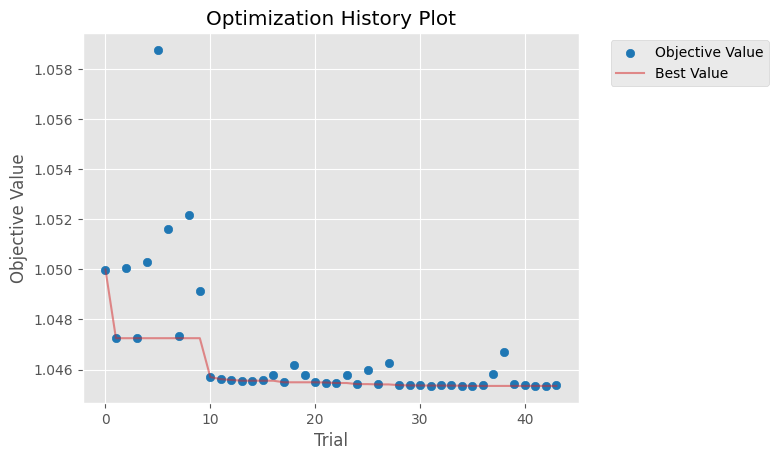

/tmp/ipykernel_23/1840419637.py:87: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


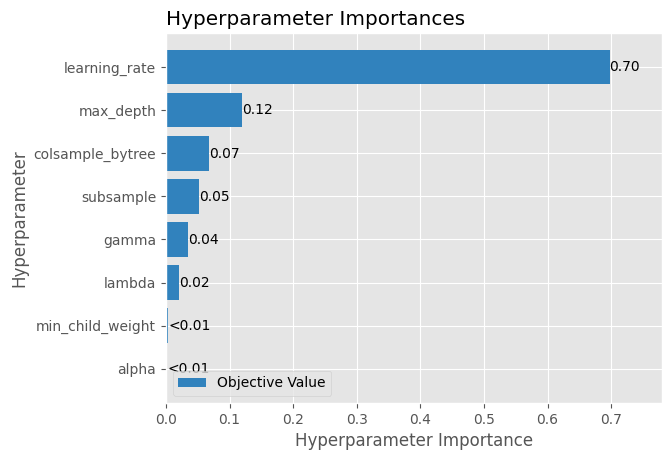

/tmp/ipykernel_23/1840419637.py:90: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


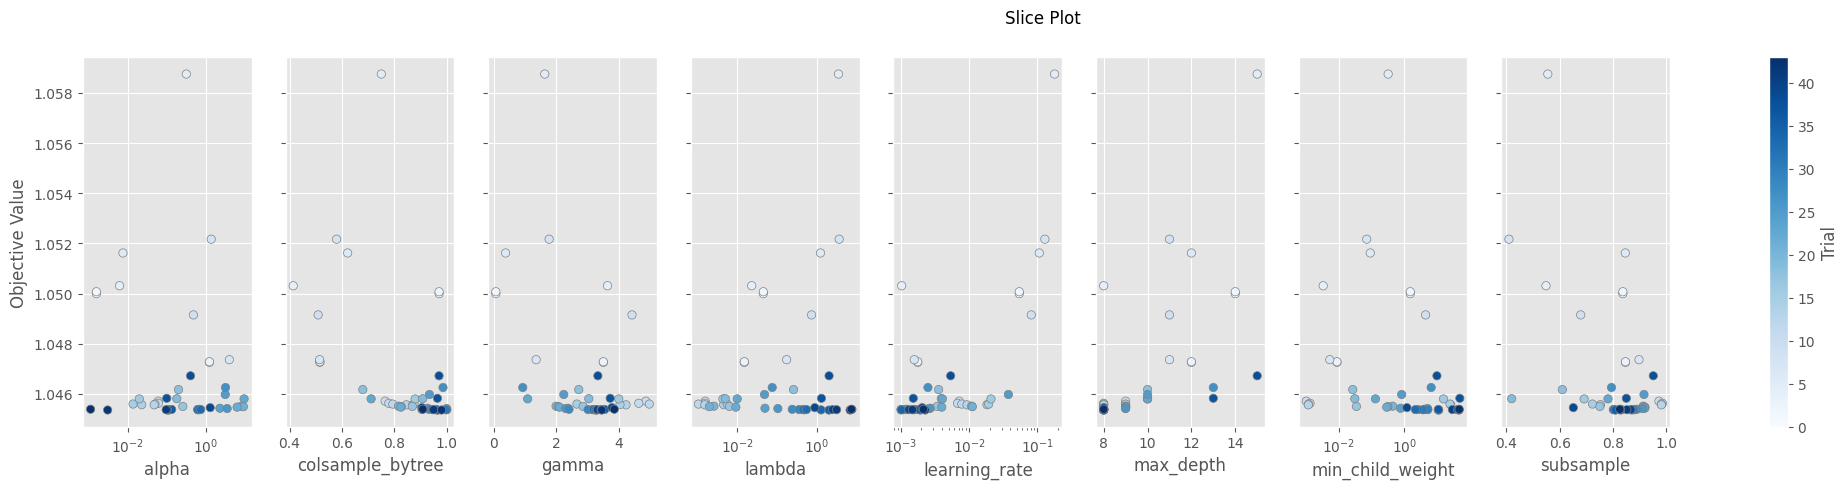

In [10]:
import json
import optuna
import torch
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
import matplotlib.pyplot as plt

if HYPER_OPT:
    fixed_params = {
        "n_estimators": 10000,
        "objective": "reg:squarederror",  # XGBoost regression objective
        "tree_method": "gpu_hist" if torch.cuda.is_available() else "auto",
        "verbosity": 0,
        "enable_categorical": True
    }
    
    # Define the Optuna objective function
    def objective(trial):
        # Define hyperparameter space
        varying_params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 8, 15),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 50, log=True),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),
            "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True)
        }

        xgb_params = {**fixed_params, **varying_params}
        
        # Initialize XGBRegressor with trial parameters
        model = XGBRegressorWrapper(**xgb_params)
        
        # Evaluate using K-Fold CV with early stopping
        results = train_model_cv(\
            model, 
            X_train, 
            y_train, 
            X_test, 
            X_orig,
            cv_splits=5, 
            early_stopping_rounds=50
        )
        score = results['cv_scores'].mean()

        trial.set_user_attr("best_iteration", results['best_iteration'])
        
        return score
    
    # Prepare data
    # Replace X_train, y_train, and X_test with your data
    # Example:
    # X_train, X_test, y_train = ...
    
    # Run Optuna optimization
    study = optuna.create_study( \
        direction="minimize", 
        study_name="XGB_v1", 
        storage="sqlite:///xgb_study_v1.db", 
        load_if_exists=True,
        sampler=TPESampler(seed=666)
    )
    study.optimize(objective, n_trials=100, timeout=HYPER_OPT_TIME)
    
    # Best parameters and result
    print("Best Trial: ", study.best_trial.params)
    print("Best RMSE: ", study.best_value)

    xgb_best_params = {**fixed_params, **study.best_trial.params}

    xgb_best_params["n_estimators"] = study.best_trial.user_attrs.get("best_iteration", None)

    with open("xgb_best_params.json", "w") as f:
        json.dump(xgb_best_params, f, indent=4)
   
    plot_optimization_history(study)
    plt.show()
    
    plot_param_importances(study)
    plt.show()
    
    plot_slice(study)
    plt.show()

else:
    xgb_best_params = {
        "n_estimators": 8401,
        "objective": "reg:squarederror",
        "tree_method": "auto",
        "verbosity": 0,
        "enable_categorical": True,
        "learning_rate": 0.001768215377734423,
        "max_depth": 12,
        "min_child_weight": 0.008728853020978604,
        "subsample": 0.8464925012884582,
        "colsample_bytree": 0.5157352018243503,
        "gamma": 3.5042237608299063,
        "lambda": 0.014890607747597583,
        "alpha": 1.2529040614881077
    }


In [11]:
xgb_best_params

{'n_estimators': 3388,
 'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'verbosity': 0,
 'enable_categorical': True,
 'learning_rate': 0.0019183388163566096,
 'max_depth': 8,
 'min_child_weight': 11.13254860561508,
 'subsample': 0.8083537031924297,
 'colsample_bytree': 0.9656438477131202,
 'gamma': 3.2972521618813926,
 'lambda': 2.065890933462914,
 'alpha': 0.10641557397683166}

In [12]:
xgb_best_params["n_estimators"] = 10000

# Model Training

In [13]:
# Initialize a CatBoost Regressor
model = XGBRegressorWrapper(**xgb_best_params)

# Use the train_model function to train and evaluate the model
results = train_model_cv(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    X_orig=X_orig,
    early_stopping_rounds=100,
    cv_splits=7
)

Training fold 1...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 1.0491
Training fold 2...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 1.0421
Training fold 3...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 1.0463
Training fold 4...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 1.0426
Training fold 5...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 5 RMSE: 1.0469
Training fold 6...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 6 RMSE: 1.0479
Training fold 7...


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 7 RMSE: 1.0422
Mean CV RMSE: 1.0453 ± 0.0027


In [14]:
mean_score = np.mean(results["cv_scores"])
std_score = np.std(results["cv_scores"])

# Prepare the data
data = {
    "mean_score": mean_score,
    "std_score": std_score
}

# Save to a JSON file
with open("score.json", "w") as json_file:
    json.dump(data, json_file, indent=4)  # Use `indent` for readability

In [15]:
import joblib

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
oof_preds_df.to_csv("oof_preds.csv", index=False)
print("OOF predictions saved to oof_preds.csv.")

test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
oof_preds_df.to_csv("test_preds.csv", index=False)
print("Test predictions saved to oof_preds.csv.")

joblib.dump(results["models"], "xgboost_models.pkl")

OOF predictions saved to oof_preds.csv.
Test predictions saved to oof_preds.csv.


['xgboost_models.pkl']

# Submission

In [16]:
y_pred = np.expm1(results['test_preds'])

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

submission.to_csv('submission.csv', index=False)